In [1]:
import get_data as get_data
import collections
import glob
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Dataset:
    def __init__(self):
        dataset_dir = "./datasets/"

        #SUBSETS = "train dev test".split()
        SUBSETS = ["train"]


        self.datasets = collections.defaultdict(list)

        for subset in SUBSETS:
            for filename in glob.glob(dataset_dir + subset + "/*"):
                with open(filename, 'r') as f:
                    self.datasets[subset].append(json.load(f))

        self.all_pairs = sum(self.datasets.values(), [])
        
    def get_data(self):        
        return self.all_pairs
    
    def get_data_info(self):
        def total_and_average_len(list_of_lists):
            big_list = sum(list_of_lists, [])
            return len(big_list), len(big_list)/len(list_of_lists)
        
        def count_dataset(pairs, subset):
            # TODO: Add double-annotated and adjudicated
            review_total, review_average = total_and_average_len([pair["review_sentences"] for pair in pairs])
            rebuttal_total, rebuttal_average = total_and_average_len([pair["rebuttal_sentences"] for pair in pairs])
            return {
                "subset":subset,
                "pairs": len(pairs),
                "forums": len(set(pair["metadata"]["forum_id"] for pair in pairs)),
                "adjudicated": len([pair for pair in pairs if pair["metadata"]["annotator"] == "anno0"]),
                "review_sentences": review_total,
                "rebuttal_sentences": rebuttal_total,
                "review_avg_sentences": review_average,
                "rebuttal_avg_sentences": rebuttal_average,

            }
        # Distribution of examples over sets
        df_dicts = [count_dataset(pairs, subset) for subset, pairs in self.datasets.items()]
        df = pd.DataFrame.from_dict(df_dicts)
        return df
    
    def get_review_df(self):
        df = pd.DataFrame({'review_id':[],'rating':[], 'sentence_index':[], 'text':[], 'coarse':[], 'fine':[], 'asp':[], 'pol':[]},
              columns = ['review_id', 'sentence_index', 'text', 'coarse', 'fine', 'asp', 'pol'])
    
        for pair in self.all_pairs:
            rs = pd.json_normalize(pair, record_path=['review_sentences'])
            rs['rating'] = pair['metadata']['rating']
            df = df.append(rs)

        return df
    
    def get_rebuttal_df(self):
        df = pd.DataFrame({'review_id':[],'rating':[], 'sentence_index':[], 'text':[], 'coarse':[], 'fine':[]},
              columns = ['review_id', 'sentence_index', 'text', 'coarse', 'fine'])
        for pair in self.all_pairs:
            rs = pd.json_normalize(pair, record_path=['rebuttal_sentences'])
            rs['rating'] = pair['metadata']['rating']
            df = df.append(rs)

        return df


In [3]:
rdf = Dataset().get_rebuttal_df()
rdf.head()

,review_id,sentence_index,text,coarse,fine,rebuttal_id,alignment,rating
0,B1euHOqi37,0.0,"Dear Reviewer,",nonarg,rebuttal_social,B1e8djk9Tm,"[context_global, None]",6.0
1,B1euHOqi37,1.0,Thank you for your valuable comments.,nonarg,rebuttal_social,B1e8djk9Tm,"[context_global, None]",6.0
2,B1euHOqi37,2.0,"We have revised our writing in the revision, and will further improve its clarity.",nonarg,rebuttal_social,B1e8djk9Tm,"[context_global, None]",6.0
3,B1euHOqi37,3.0,Please find our response as follows.,nonarg,rebuttal_structuring,B1e8djk9Tm,"[context_in-rebuttal, None]",6.0
4,B1euHOqi37,4.0,"- Algorithm 1 does not include mitosis, which may have an effect on the resulting approximation.",nonarg,rebuttal_structuring,B1e8djk9Tm,"[context_sentences, [7]]",6.0


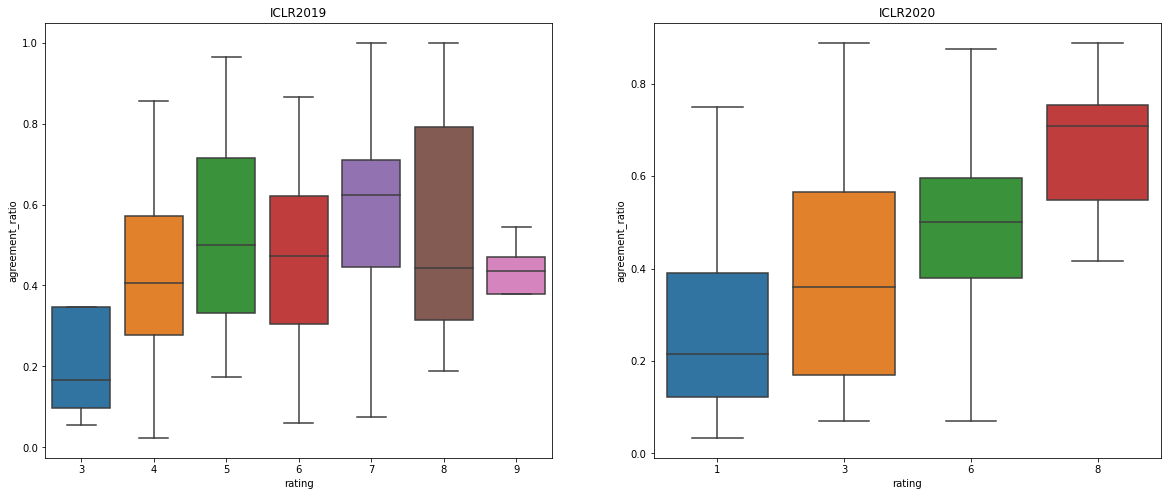

In [4]:
rdf_ = rdf.groupby(['review_id', 'coarse']).agg({'sentence_index':'count'})
rdfx = rdf.groupby(['review_id']).agg({'sentence_index':'count'})
# rdfx.head()
ratios = []
for review_id in rdf.review_id.unique():
    # typo:total request ratio
    try:
        concur = np.round(rdf_.loc[review_id, 'concur'].values[0]/rdfx.loc[review_id].values[0], 3)
    except:
        concur = np.nan
        
    ratios.append([review_id, concur])
dff = pd.DataFrame(ratios, columns=['review_id', 'agreement_ratio'])

pairdff = pd.json_normalize([pair['metadata'] for pair in Dataset().get_data()])
pairdff = pairdff.merge(dff, on='review_id', how='left')

fig, (s0, s1) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

confdf = pairdff.loc[pairdff.conference == 'ICLR2019']
sns.boxplot(x='rating', y='agreement_ratio', data=confdf, showfliers=False, ax=s0)
s0.set_title('ICLR2019')

confdf = pairdff.loc[pairdff.conference == 'ICLR2020']
sns.boxplot(x='rating', y='agreement_ratio', data=confdf, showfliers=False, ax=s1)
_ = s1.set_title('ICLR2020')

# sns.boxplot(x='rating', y='agreement_ratio', data=pairdff, showfliers=False, ax=s0)


# agreement ratio in general increases till rating 7 (not much for 9?!) ICLR 19
# agreement ratio increases for ICLR 2020

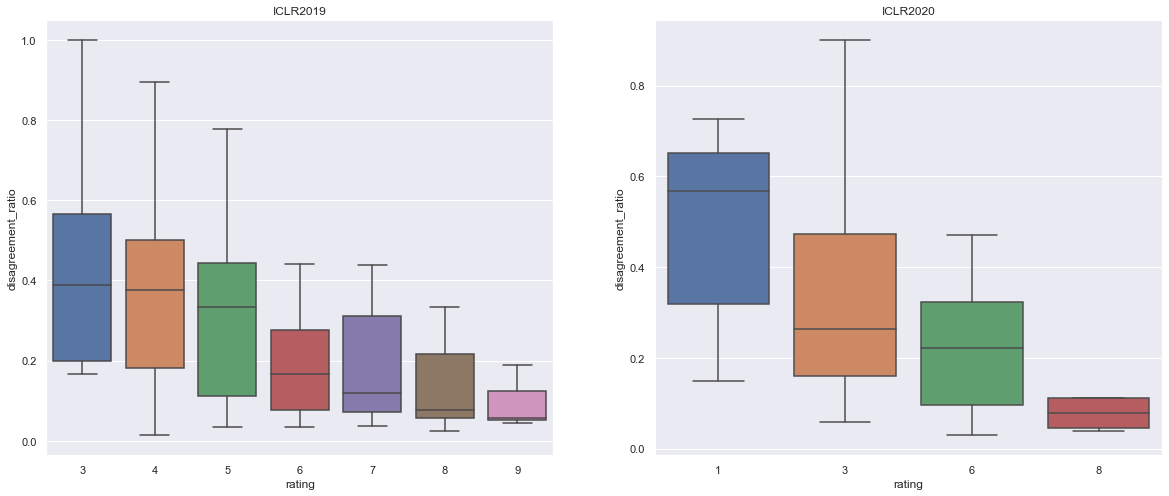

In [31]:
rdf_ = rdf.groupby(['review_id', 'coarse']).agg({'sentence_index':'count'})
rdfx = rdf.groupby(['review_id']).agg({'sentence_index':'count'})
# rdfx.head()
ratios = []
for review_id in rdf.review_id.unique():
    # typo:total request ratio
    try:
        concur = np.round(rdf_.loc[review_id, 'dispute'].values[0]/rdfx.loc[review_id].values[0], 3)
    except:
        concur = np.nan
        
    ratios.append([review_id, concur])
dff = pd.DataFrame(ratios, columns=['review_id', 'disagreement_ratio'])

pairdff = pd.json_normalize([pair['metadata'] for pair in Dataset().get_data()])
pairdff = pairdff.merge(dff, on='review_id', how='left')

fig, (s0, s1) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

confdf = pairdff.loc[pairdff.conference == 'ICLR2019']
sns.boxplot(x='rating', y='disagreement_ratio', data=confdf, showfliers=False, ax=s0)
s0.set_title('ICLR2019')

confdf = pairdff.loc[pairdff.conference == 'ICLR2020']
sns.boxplot(x='rating', y='disagreement_ratio', data=confdf, showfliers=False, ax=s1)
_ = s1.set_title('ICLR2020')

# sns.boxplot(x='rating', y='agreement_ratio', data=pairdff, showfliers=False, ax=s0)

Why do rating 3 papers tend to be more accepting of the review comments, whereas rating 4 are the most argumentative (disputing?)


# stark decreasing disaggrement ratio for both conferences

In [5]:
revdf = Dataset().get_review_df()
revdf.head(5)

,review_id,sentence_index,text,coarse,fine,asp,pol,rating
0,B1euHOqi37,0.0,The present paper proposes a fast approximation to the softmax computation when the number of classes is very large.,arg_structuring,arg-structuring_summary,none,none,6.0
1,B1euHOqi37,1.0,This is typically a bottleneck in deep learning architectures.,arg_structuring,arg-structuring_summary,none,none,6.0
2,B1euHOqi37,2.0,The approximation is a sparse two-layer mixture of experts.,arg_structuring,arg-structuring_summary,none,none,6.0
3,B1euHOqi37,3.0,"The paper lacks rigor and the writing is of low quality, both in its clarity and its grammar.",arg_evaluative,none,asp_clarity,pol_negative,6.0
4,B1euHOqi37,4.0,See a list of typos below.,arg_structuring,arg-structuring_heading,none,none,6.0


In [6]:
ctx = rdf.loc[rdf.loc[:, 'alignment'].apply(lambda x: x[1] != None)]

ctx.loc[:,'rev_idx'] = rdf.loc[:, 'alignment'].apply(lambda x: x[1]).reset_index()['alignment']
ctx = ctx.reset_index()
ctx.head()


## now find the aspect for all these rev_idx and see their polarity , create some hypothesis

C:\Users\disha\miniconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,index,review_id,sentence_index,text,coarse,fine,rebuttal_id,alignment,rating,rev_idx
0,4,B1euHOqi37,4.0,"- Algorithm 1 does not include mitosis, which may have an effect on the resulting approximation.",nonarg,rebuttal_structuring,B1e8djk9Tm,"[context_sentences, [7]]",6.0,[7]
1,5,B1euHOqi37,5.0,Mitosis training can be considered as executing Algorithm 1 for multiple times with an increasing number of experts and inherited initialization from last round by changing W^e and W^g.,dispute,rebuttal_reject-criticism,B1e8djk9Tm,"[context_sentences, [7]]",6.0,[7]
2,6,B1euHOqi37,6.0,"Also, training with mitosis achieves similar performance as training without it shown in Appendix B, Figure (a).",dispute,rebuttal_reject-criticism,B1e8djk9Tm,"[context_sentences, [7]]",6.0,[7]
3,7,B1euHOqi37,7.0,"- How are the lambda and threshold parameters tuned? The authors mention a validation set, are they just exhaustively explored on a 3D grid on the validation set?",nonarg,rebuttal_structuring,B1e8djk9Tm,"[context_sentences, [8]]",6.0,[8]
4,8,B1euHOqi37,8.0,The hyper-parameters related to DS-softmax (such as lambda) are tuned according to the performance on a validation dataset.,concur,rebuttal_answer,B1e8djk9Tm,"[context_sentences, [8]]",6.0,[8]


In [7]:
for i, row in ctx.iterrows():
    # find the review sentence
    reviews = ctx.loc[i, 'rev_idx']
    review_id = row[1]
    if (reviews == None):
        reviews = []
        #append emptyiies
    data = []
    for rev_idx in reviews:
        rev = revdf.loc[(revdf.review_id == review_id) & (revdf.sentence_index == rev_idx)]
        data.append([rev.text, rev.coarse, rev.fine, rev.asp, rev.pol])
        break
    break


In [8]:
#constructive feedback

df = revdf.groupby(['review_id', 'coarse']).agg({'sentence_index':'count'}).loc[:, ['arg_evaluative', 'arg_request'],:]

cons_feed = []
for review_id in revdf.review_id.unique():
    try:
        cons_feed.append([review_id, np.round(df.loc[review_id, 'arg_request'].values[0]/df.loc[review_id, 'arg_evaluative'].values[0], 3)])
    except:
        cons_feed.append([review_id, np.nan])
    
df = pd.DataFrame(cons_feed, columns=['review_id', 'req_eval_ratio'])
df.head()

,review_id,req_eval_ratio
0,B1euHOqi37,1.714
1,B1ez1LvJcB,1.143
2,B1g0bJk5h7,0.800
3,B1g4z20Vs7,0.200
4,B1gcyfVOn7,3.000


In [9]:
# df = df.fillna(df.mean())

In [10]:
pairdf = pd.json_normalize([pair['metadata'] for pair in Dataset().get_data()])
pairdf = pairdf.merge(df, on='review_id', how='left')
pairdf.head(1)

,forum_id,review_id,rebuttal_id,title,reviewer,rating,conference,permalink,annotator,req_eval_ratio
0,rJl2E3AcF7,B1euHOqi37,B1e8djk9Tm,Doubly Sparse: Sparse Mixture of Sparse Experts for Efficient Softmax Inference,AnonReviewer2,6,ICLR2019,https://openreview.net/forum?id=rJl2E3AcF7&noteId=B1e8djk9Tm,anno10,1.714


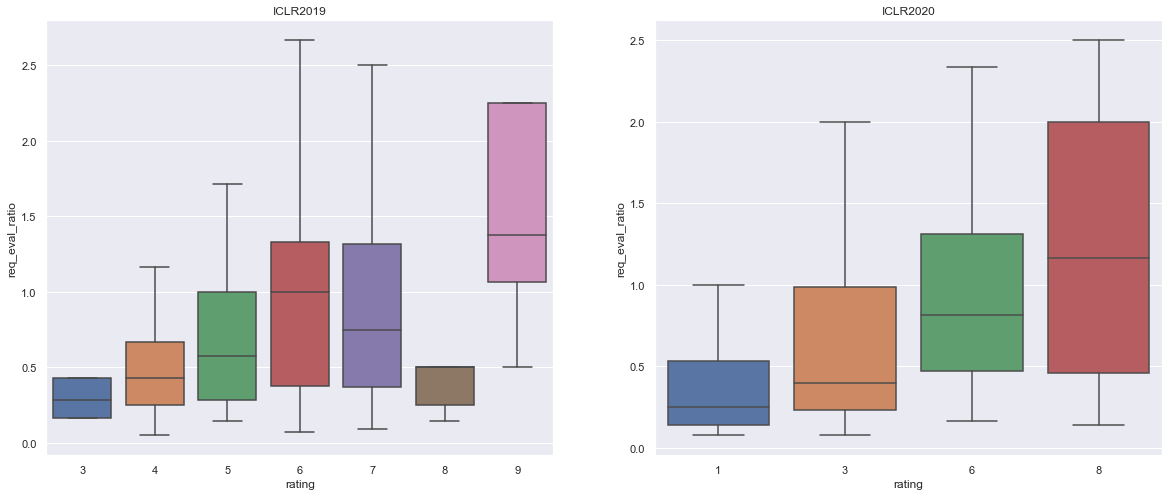

In [11]:
sns.set(rc={'figure.figsize':(10,8)})

fig, (s0, s1) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

confdf = pairdf.loc[pairdf.conference == 'ICLR2019']
sns.boxplot(x='rating', y='req_eval_ratio', data=confdf, showfliers=False, ax=s0)
s0.set_title('ICLR2019')

confdf = pairdf.loc[pairdf.conference == 'ICLR2020']
sns.boxplot(x='rating', y='req_eval_ratio', data=confdf, showfliers=False, ax=s1)
_ = s1.set_title('ICLR2020')

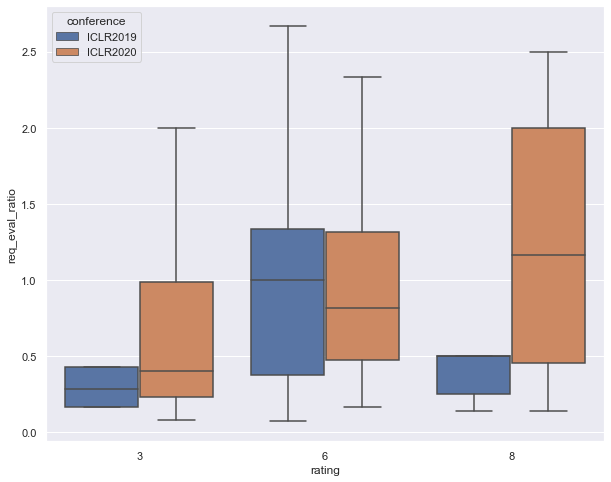

In [12]:
rating_df = pairdf.loc[pairdf.rating.isin([3,6,8])]
_ = sns.boxplot(x='rating', y='req_eval_ratio', data=rating_df, hue='conference', showfliers=False)

## ICLR2020 constructive feedback increasing with rating
## ICLR2019 ingeneral increase too (except 8)
## 9 seems to have high constructive feedback

## having trouble merging review info with rebuttal contexts (1: many mapping)

In [13]:
revdf.fine.unique()

array(['arg-structuring_summary', 'none', 'arg-structuring_heading',
       'arg-request_explanation', 'arg-request_edit',
       'arg-request_experiment', 'arg-request_typo',
       'arg-request_clarification', 'arg-structuring_quote',
       'arg-request_result'], dtype=object)

In [14]:
# evaluative counts
dfe = revdf.groupby(['review_id', 'coarse']).agg({'sentence_index':'count'}).loc[:, ['arg_evaluative', 'arg_request'],:]
# dfe.head()
# request types counts
dfr = revdf.groupby(['review_id', 'fine']).agg({'sentence_index':'count'})
dfr.head(10)

sentence_index
review_id  fine                                   
B1euHOqi37 arg-request_edit                     10
           arg-request_explanation               2
           arg-structuring_heading               2
           arg-structuring_summary               3
           none                                  7
B1ez1LvJcB arg-request_edit                      2
           arg-request_experiment                4
           arg-request_typo                      2
           arg-structuring_heading               1
           arg-structuring_summary               2

In [15]:
cons_feed = []
for review_id in revdf.review_id.unique():
    # typo:total request ratio
    try:
        typo_percent = np.round(dfr.loc[review_id, 'arg-request_typo'].values[0]/dfe.loc[review_id, 'arg_request'].values[0], 3)
    except:
        typo_percent = np.nan
        
    try:
        clar_percent = np.round(dfr.loc[review_id, 'arg-request_clarification'].values[0]/dfe.loc[review_id, 'arg_request'].values[0], 3)
    except:
        clar_percent = np.nan
    try:
        edit = np.round(dfr.loc[review_id, 'arg-request_edit'].values[0]/dfe.loc[review_id, 'arg_evaluative'].values[0], 3)
    except:
        edit = np.nan
        
    try:
        expl = np.round(dfr.loc[review_id, 'arg-request_explanation'].values[0]/dfe.loc[review_id, 'arg_evaluative'].values[0], 3)
    except:
        expl = np.nan  
        
    try:
        exper = np.round(dfr.loc[review_id, 'arg-request_experiment'].values[0]/dfe.loc[review_id, 'arg_evaluative'].values[0], 3)
    except:
        exper = np.nan
        
    try:
        typo = np.round(dfr.loc[review_id, 'arg-request_typo'].values[0]/dfe.loc[review_id, 'arg_evaluative'].values[0], 3)
    except:
        typo = np.nan
        
    try:
        result = np.round(dfr.loc[review_id, 'arg-request_result'].values[0]/dfe.loc[review_id, 'arg_evaluative'].values[0], 3)
    except:
        result = np.nan
    
    try:
        clar = np.round(dfr.loc[review_id, 'arg-request_clarification'].values[0]/dfe.loc[review_id, 'arg_evaluative'].values[0], 3)
    except:
        clar = np.nan
        
    cons_feed.append([review_id, typo_percent, clar_percent, edit, expl, exper, typo, result, clar])
        
# multiple ratios df    
dfm = pd.DataFrame(cons_feed, columns=['review_id', 'typo_percent', 'clar_percent', 'edit_eval_ratio', 'expl_eval_ratio', 'exper_eval_ratio', 'typo_eval_ratio', 'result_eval_ratio', 'clar_eval_ratio'])
dfm.head()

,review_id,typo_percent,clar_percent,edit_eval_ratio,expl_eval_ratio,exper_eval_ratio,typo_eval_ratio,result_eval_ratio,clar_eval_ratio
0,B1euHOqi37,NaN,NaN,1.429,0.286,NaN,NaN,NaN,NaN
1,B1ez1LvJcB,0.25,NaN,0.286,NaN,0.571,0.286,NaN,NaN
2,B1g0bJk5h7,NaN,NaN,NaN,0.200,0.600,NaN,NaN,NaN
3,B1g4z20Vs7,1.00,NaN,NaN,NaN,NaN,0.200,NaN,NaN
4,B1gcyfVOn7,NaN,NaN,NaN,NaN,3.000,NaN,NaN,NaN


In [16]:
dfm.count()

review_id            251
typo_percent          43
clar_percent          87
edit_eval_ratio      100
expl_eval_ratio      141
exper_eval_ratio     116
typo_eval_ratio       43
result_eval_ratio     30
clar_eval_ratio       86
dtype: int64

In [17]:
pairdf = pd.json_normalize([pair['metadata'] for pair in Dataset().get_data()])
pairdf = pairdf.merge(dfm, on='review_id', how='left')
pairdf.head(1)

,forum_id,review_id,rebuttal_id,title,reviewer,rating,conference,permalink,annotator,typo_percent,clar_percent,edit_eval_ratio,expl_eval_ratio,exper_eval_ratio,typo_eval_ratio,result_eval_ratio,clar_eval_ratio
0,rJl2E3AcF7,B1euHOqi37,B1e8djk9Tm,Doubly Sparse: Sparse Mixture of Sparse Experts for Efficient Softmax Inference,AnonReviewer2,6,ICLR2019,https://openreview.net/forum?id=rJl2E3AcF7&noteId=B1e8djk9Tm,anno10,NaN,NaN,1.429,0.286,NaN,NaN,NaN,NaN


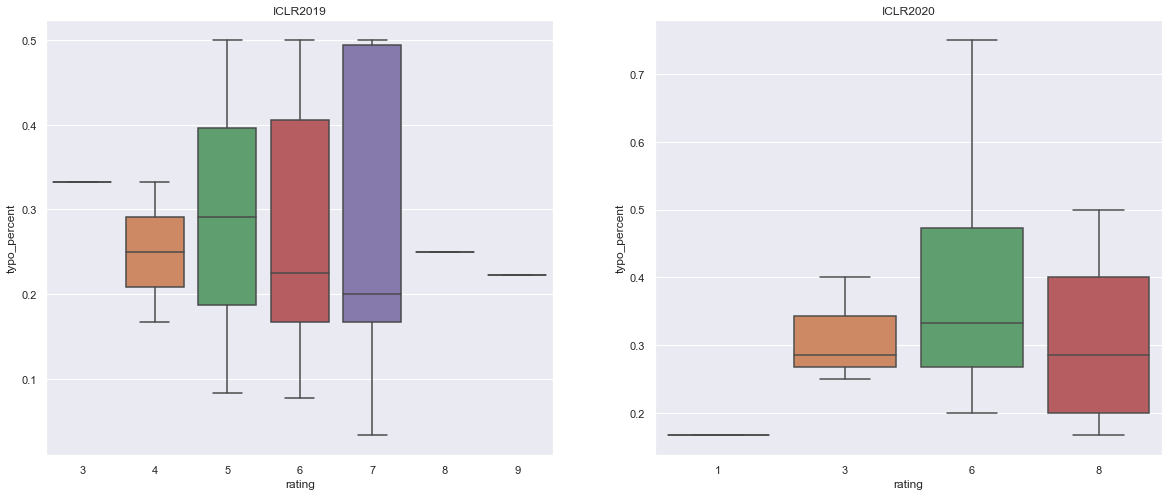

In [18]:
sns.set(rc={'figure.figsize':(10,8)})

fig, (s0, s1) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

conf19 = pairdf.loc[pairdf.conference == 'ICLR2019']
sns.boxplot(x='rating', y='typo_percent', data=conf19, showfliers=False, ax=s0)
s0.set_title('ICLR2019')

conf20 = pairdf.loc[pairdf.conference == 'ICLR2020']
sns.boxplot(x='rating', y='typo_percent', data=conf20, showfliers=False, ax=s1)
_ = s1.set_title('ICLR2020')

3.8 What is the ratio of typo/clarity to non-typo/clarity feedback in different reviews, what is the distribution (typos is not really super constructive)

# as such no typo request excess (very random) (all less than 0.5, most less than 0.4)

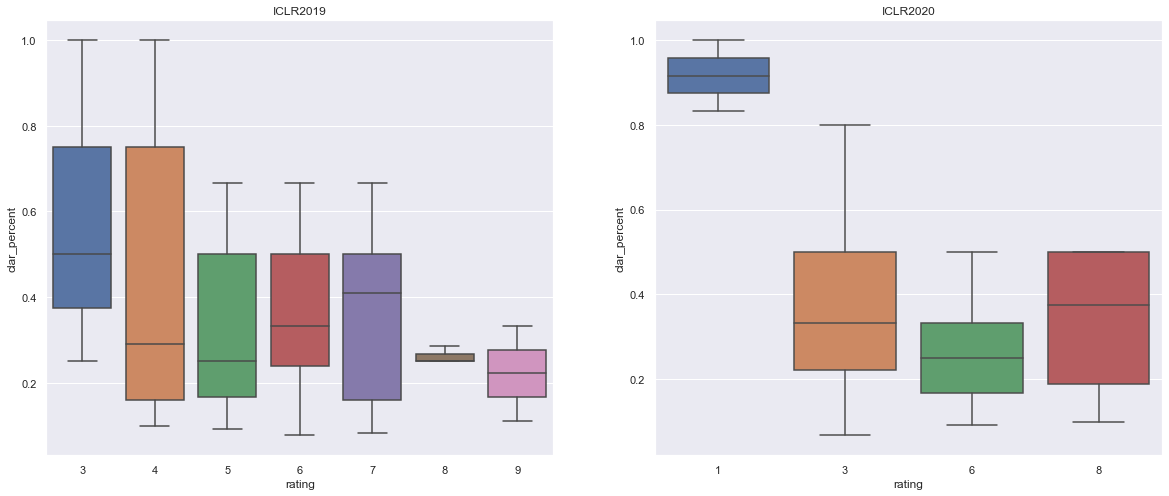

In [19]:
fig, (s0, s1) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

conf19 = pairdf.loc[pairdf.conference == 'ICLR2019']
sns.boxplot(x='rating', y='clar_percent', data=conf19, showfliers=False, ax=s0)
s0.set_title('ICLR2019')

conf20 = pairdf.loc[pairdf.conference == 'ICLR2020']
sns.boxplot(x='rating', y='clar_percent', data=conf20, showfliers=False, ax=s1)
_ = s1.set_title('ICLR2020')

# ICLR 2020 has extremely high clarity requests for rating 1 (0.9~)
# ICLR19 has more than 50% clarity requests (for ~50% reviews) for ratings 3, 4.
# ICLR19 shows that rating 8, 9 has minimum clarity requests

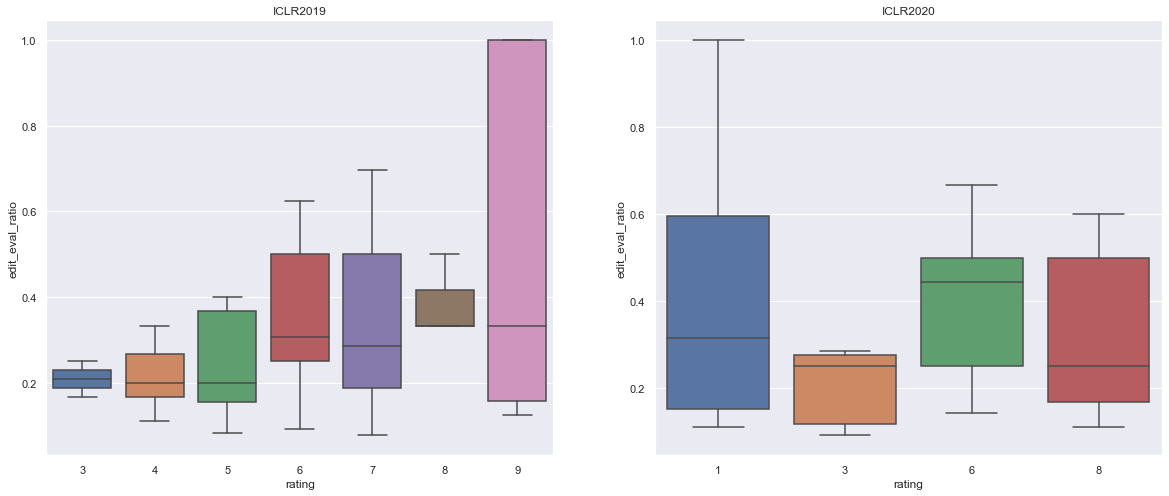

In [20]:
sns.set(rc={'figure.figsize':(10,8)})

fig, (s0, s1) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

conf19 = pairdf.loc[pairdf.conference == 'ICLR2019']
sns.boxplot(x='rating', y='edit_eval_ratio', data=conf19, showfliers=False, ax=s0)
s0.set_title('ICLR2019')

conf20 = pairdf.loc[pairdf.conference == 'ICLR2020']
sns.boxplot(x='rating', y='edit_eval_ratio', data=conf20, showfliers=False, ax=s1)
_ = s1.set_title('ICLR2020')

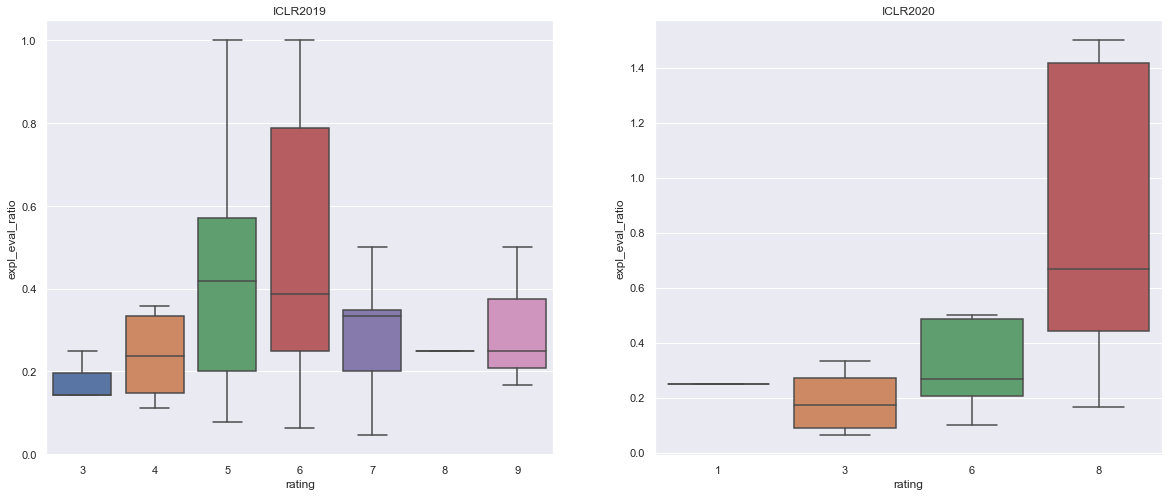

In [21]:
fig, (s2, s3) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

sns.boxplot(x='rating', y='expl_eval_ratio', data=conf19, showfliers=False, ax=s2)
s2.set_title('ICLR2019')

sns.boxplot(x='rating', y='expl_eval_ratio', data=conf20, showfliers=False, ax=s3)
_ = s3.set_title('ICLR2020')

# explanation evaluation ratio increases with rating in iclr 2020
# for rating 5, explanation ratio is higher than others

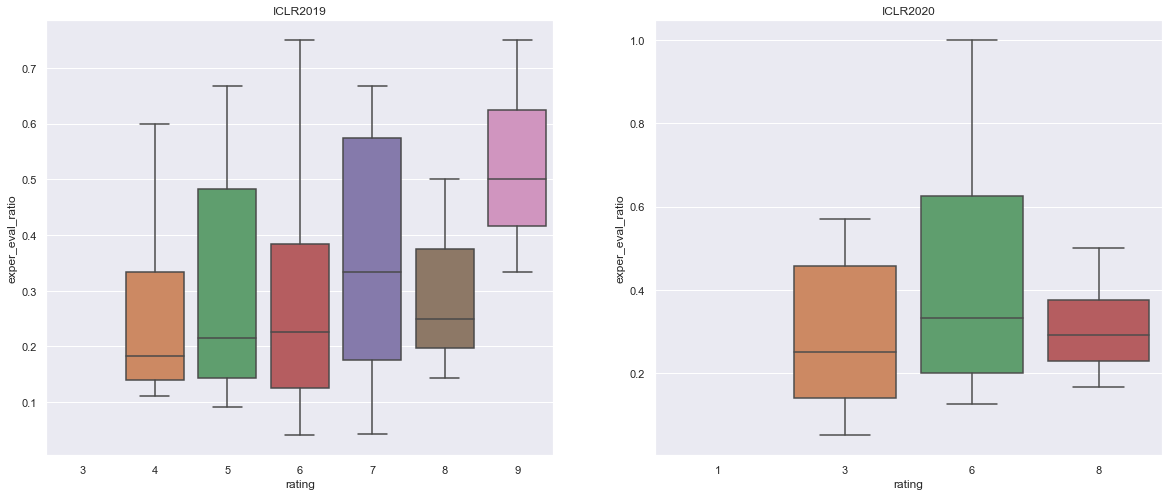

In [22]:
fig, (s4, s5) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

sns.boxplot(x='rating', y='exper_eval_ratio', data=conf19, showfliers=False, ax=s4)
s4.set_title('ICLR2019')

sns.boxplot(x='rating', y='exper_eval_ratio', data=conf20, showfliers=False, ax=s5)
_ = s5.set_title('ICLR2020')

# experiment evaluation ratio increases with rating in iclr 2019 except rating 8
# for rating 9 experiment ratio is higher than others

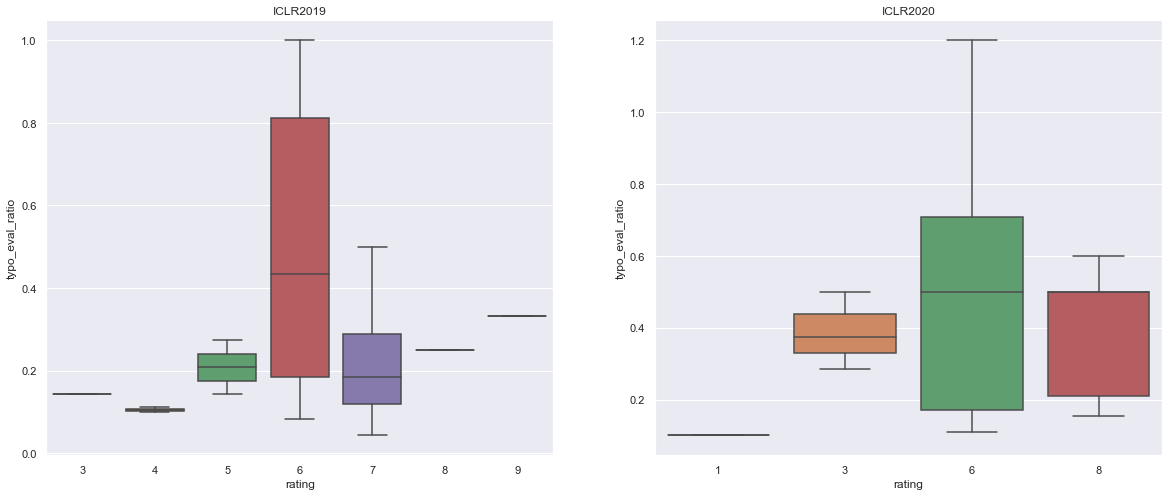

In [23]:
fig, (s6, s7) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})


sns.boxplot(x='rating', y='typo_eval_ratio', data=conf19, showfliers=False, ax=s6)
s6.set_title('ICLR2019')

sns.boxplot(x='rating', y='typo_eval_ratio', data=conf20, showfliers=False, ax=s7)
_ = s7.set_title('ICLR2020')

# typo evaluation ratio is high for rating 6 for both conferences


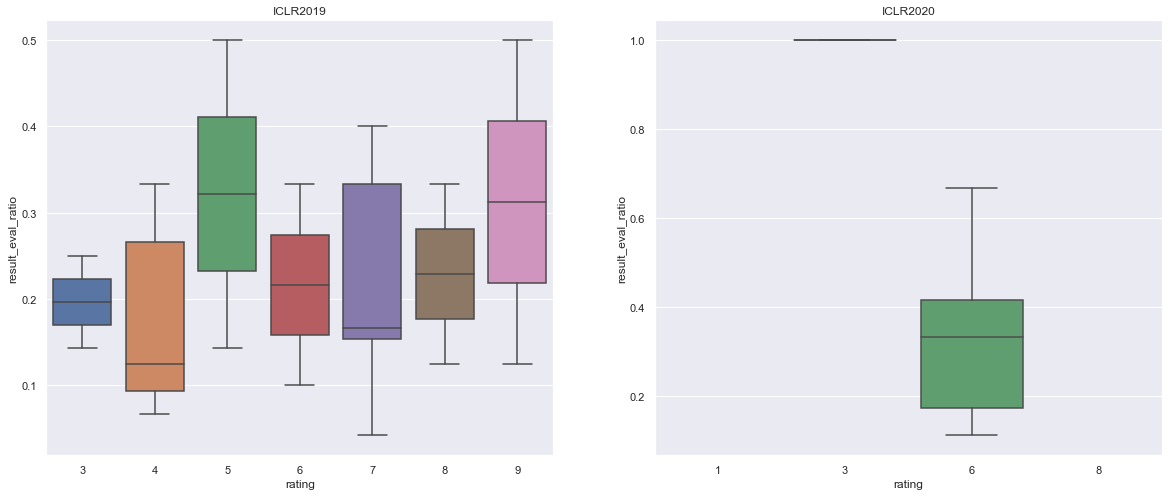

In [24]:
fig, (s8, s9) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

sns.boxplot(x='rating', y='result_eval_ratio', data=conf19, showfliers=False, ax=s8)
s8.set_title('ICLR2019')

sns.boxplot(x='rating', y='result_eval_ratio', data=conf20, showfliers=False, ax=s9)
_ = s9.set_title('ICLR2020')

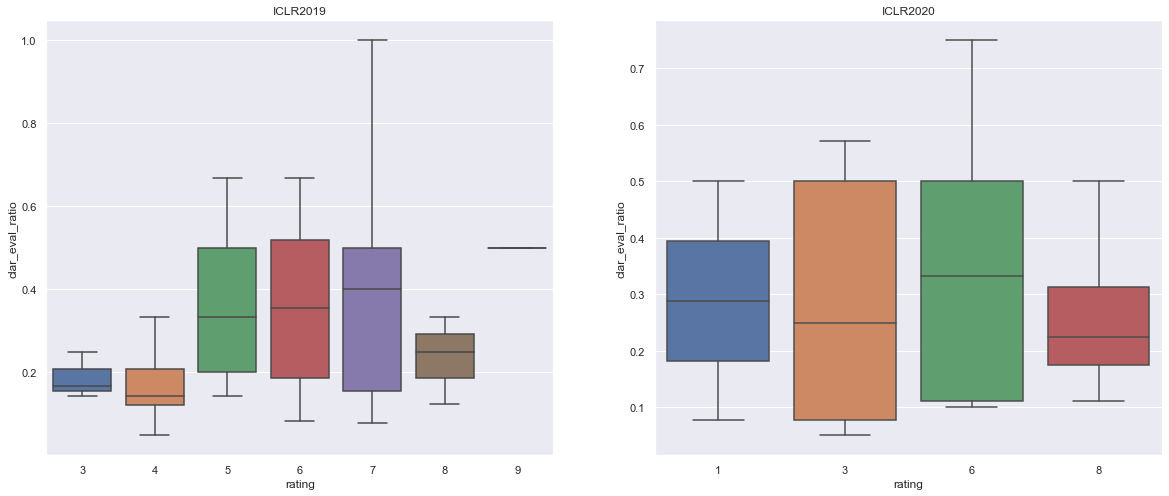

In [25]:
fig, (s10, s11) = plt.subplots(1, 2, figsize=(20,8), gridspec_kw={'width_ratios': [2, 2]})

sns.boxplot(x='rating', y='clar_eval_ratio', data=conf19, showfliers=False, ax=s10)
s10.set_title('ICLR2019')

sns.boxplot(x='rating', y='clar_eval_ratio', data=conf20, showfliers=False, ax=s11)
_ = s11.set_title('ICLR2020')



# clar lowest for rating 1, high for higher ratings 2019
# whats weird is that result lower for rating 4 , high for rating 5


In [26]:
dfm.result_eval_ratio.describe()

count    30.000000
mean      0.272833
std       0.207745
min       0.042000
25%       0.125000
50%       0.211000
75%       0.333000
max       1.000000
Name: result_eval_ratio, dtype: float64

## Request sentences rating 3 | 8

In [27]:
revdf.head()

,review_id,sentence_index,text,coarse,fine,asp,pol,rating
0,B1euHOqi37,0.0,The present paper proposes a fast approximation to the softmax computation when the number of classes is very large.,arg_structuring,arg-structuring_summary,none,none,6.0
1,B1euHOqi37,1.0,This is typically a bottleneck in deep learning architectures.,arg_structuring,arg-structuring_summary,none,none,6.0
2,B1euHOqi37,2.0,The approximation is a sparse two-layer mixture of experts.,arg_structuring,arg-structuring_summary,none,none,6.0
3,B1euHOqi37,3.0,"The paper lacks rigor and the writing is of low quality, both in its clarity and its grammar.",arg_evaluative,none,asp_clarity,pol_negative,6.0
4,B1euHOqi37,4.0,See a list of typos below.,arg_structuring,arg-structuring_heading,none,none,6.0


In [28]:
poldf= revdf.loc[(revdf.coarse == 'arg_request') & (revdf.rating == 3), :].groupby(['coarse','pol']).agg({'pol':'count'})
poldf.head(30)

pol
coarse      pol              
arg_request none            1
            pol_negative   45
            pol_neutral    61
            pol_positive    1

In [29]:
poldf8= revdf.loc[(revdf.coarse == 'arg_request') & (revdf.rating == 8), :].groupby(['coarse','pol']).agg({'pol':'count'})
poldf8.head(30)

pol
coarse      pol              
arg_request none            1
            pol_negative   32
            pol_neutral    68
            pol_positive    1


# polarity negative lesser for rating 8 than 3 (45 > 32)


In [30]:
revdf.loc[(revdf.coarse == 'arg_request') & (revdf.rating == 8), :].head(10)

,review_id,sentence_index,text,coarse,fine,asp,pol,rating
17,B1lrh6UpYS,17.0,"- I don't understand why the authors say that their space ""interpolates smoothly"" just because the limit in the curvature is the same from the left and right side.",arg_request,arg-request_explanation,asp_soundness-correctness,pol_negative,8.0
18,B1lrh6UpYS,18.0,"For example, the absolute value function has the same limit from the left and the right at 0, but it's not differentiable there. Is it actually true that if we take the derivatives of the piecewise hyperbolic/spherical distance function that it's differentiable at c=0?",arg_request,arg-request_explanation,asp_soundness-correctness,pol_neutral,8.0
21,B1lrh6UpYS,21.0,I do recommend that the authors compare against those results in a future update of this work.,arg_request,arg-request_experiment,asp_substance,pol_neutral,8.0
26,B1lrh6UpYS,26.0,You probably have to limit the operation to a half-sphere (there's some ideas for this in Gu et al).,arg_request,arg-request_edit,asp_soundness-correctness,pol_negative,8.0
27,B1lrh6UpYS,27.0,"- For the synthetic tree, why is the number of edges 2(|V|-1) rather than |V|-1?",arg_request,arg-request_explanation,asp_soundness-correctness,pol_negative,8.0
28,B1lrh6UpYS,28.0,- Are the curvatures the same for each layer for the GCNs?,arg_request,arg-request_clarification,asp_clarity,pol_neutral,8.0
29,B1lrh6UpYS,29.0,This is an interesting point to discuss (some of the NeurIPS papers I mentioned train the curvature for each layer).,arg_request,arg-request_experiment,asp_substance,pol_neutral,8.0
30,B1lrh6UpYS,30.0,"Also, how do you select the number of factors of each type?",arg_request,arg-request_clarification,asp_soundness-correctness,pol_neutral,8.0
32,B1lrh6UpYS,32.0,"The ""De Sa"" et al 2018 arxiv citation is really Sala et al and is an ICML '18 paper.",arg_request,arg-request_typo,asp_soundness-correctness,pol_neutral,8.0
33,B1lrh6UpYS,33.0,"Similarly, Gulcehre et al is a 2019 ICLR paper, and so on. It's always good to get these right.",arg_request,arg-request_typo,asp_soundness-correctness,pol_neutral,8.0
